P2P pyspore data analysis notebook. 
Expts re-done on 1/11/22 and 1/12/22 by me. Initial setup was way too slow to get a good readout on germination. Revised protocol to spot spores on the slide and let them dry in the incubator.

In [166]:
#import the pyspore utilities. Contains classes for data analysis/ file handling
import pyspore_utils as utils
import seaborn as sns
import cv2, os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\shenlab\AppData\Local\Temp/ipykernel_12444/4274881949.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  germ_clean['Time'] = (germ_clean['Time'] * 15)/60


2


[Text(0.5, 0, 'Time (min)'), Text(0, 0.5, 'Intensity (a.u.)')]

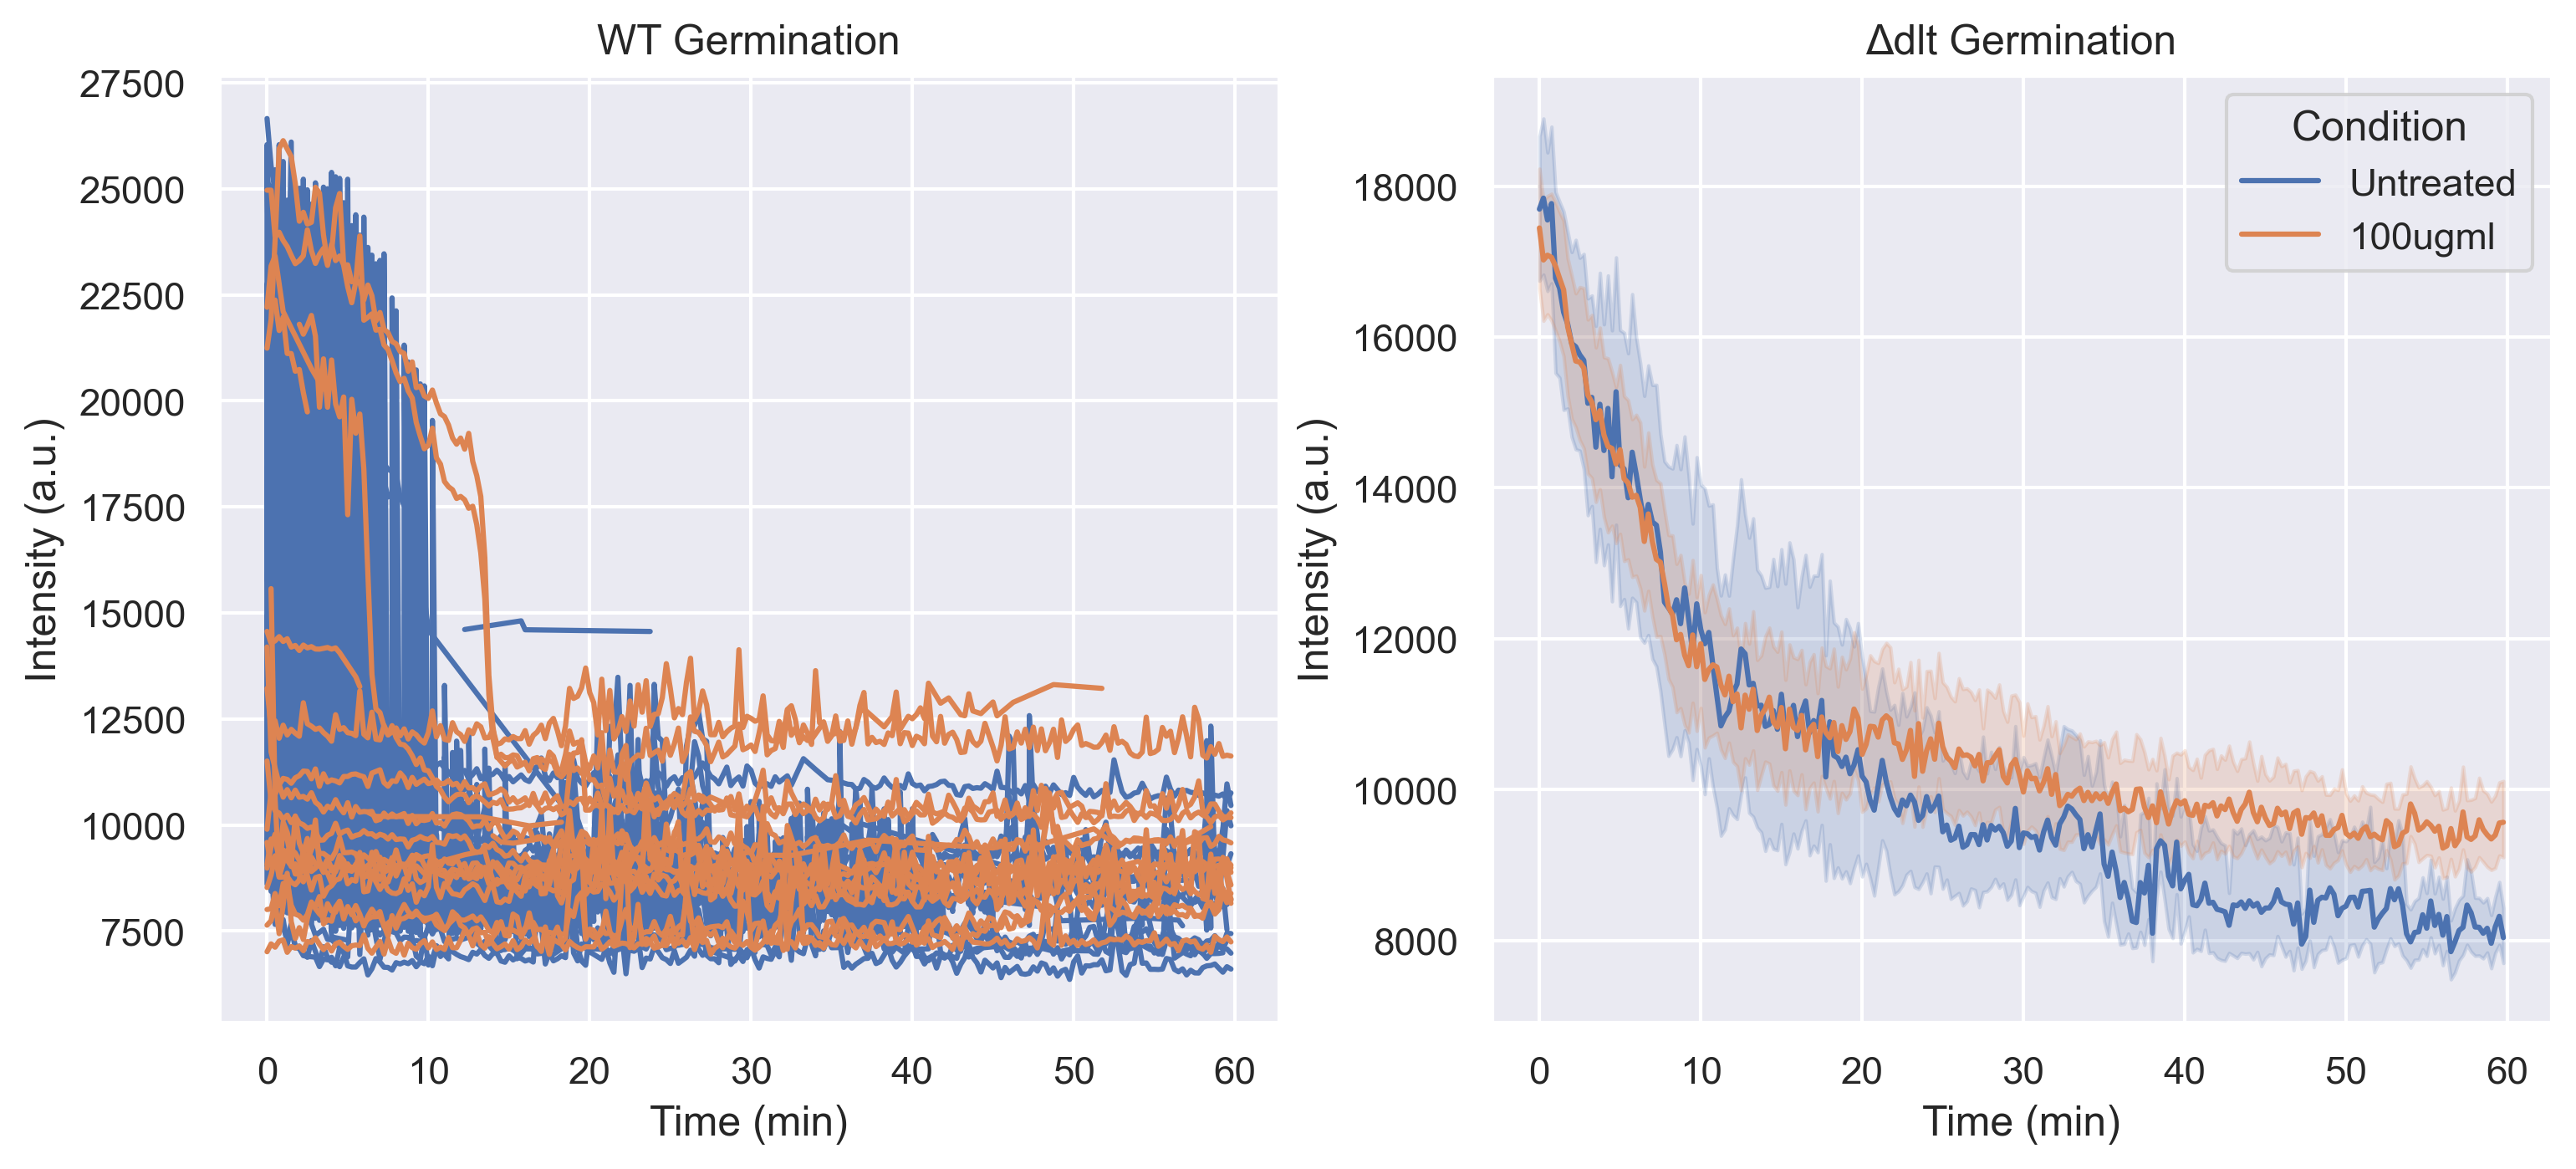

In [167]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
germ_path = 'C:/Users/shenlab/Dropbox/P2P_2022/all_data_germination_lyso.csv'
outg_path = 'C:/Users/shenlab/Dropbox/P2P_2022/all_data_outgrowth_lyso.csv'

dh = utils.DataHandling()
germination_raw = dh.read_csv(germ_path)
outgrowth_raw = dh.read_csv(outg_path)

#remove IDs for spores that are over 300pix in area at t = 0. Use df.query for this. Can also use eccentricity to get rid of clumps.
germ_clean = germination_raw.query('eccentricity > 0.85 & area < 400')
germ_clean['Time'] = (germ_clean['Time'] * 15)/60

#smoothing puts an nan for intensity in first row! Matlab function deals with this just fine...
#germ_clean['smooth_int'] = germ_clean['mean_intensity'].rolling(5).mean()

str1_germ = germ_clean[germ_clean['Strain'] == '630']
str2_germ = germ_clean[germ_clean['Strain'] == 'del_dlt']


#units allows you to plot multiple lines in the same hue. Just need to make sure that the estimator = none
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
print(len(axes))
sns.lineplot(data = str1_germ, x = 'Time', y = 'mean_intensity', hue = 'Condition', ax = axes[0], legend = False, units="ID", estimator=None)
#sns.lineplot(data = germ_clean, x = 'Time', y = 'mean_intensity', hue = 'Condition', style ='Strain')
#ax2 = plt.twinx()
sns.lineplot(data = str2_germ, x = 'Time', y = 'mean_intensity', hue = 'Condition', ax = axes[1])

axes[0].set_title('WT Germination')
axes[0].set(xlabel='Time (min)', ylabel='Intensity (a.u.)')
axes[1].set_title('Δdlt Germination')
axes[1].set(xlabel='Time (min)', ylabel='Intensity (a.u.)')

2


[Text(0.5, 0, 'Time (min)'), Text(0, 0.5, 'Area (μm^2)')]

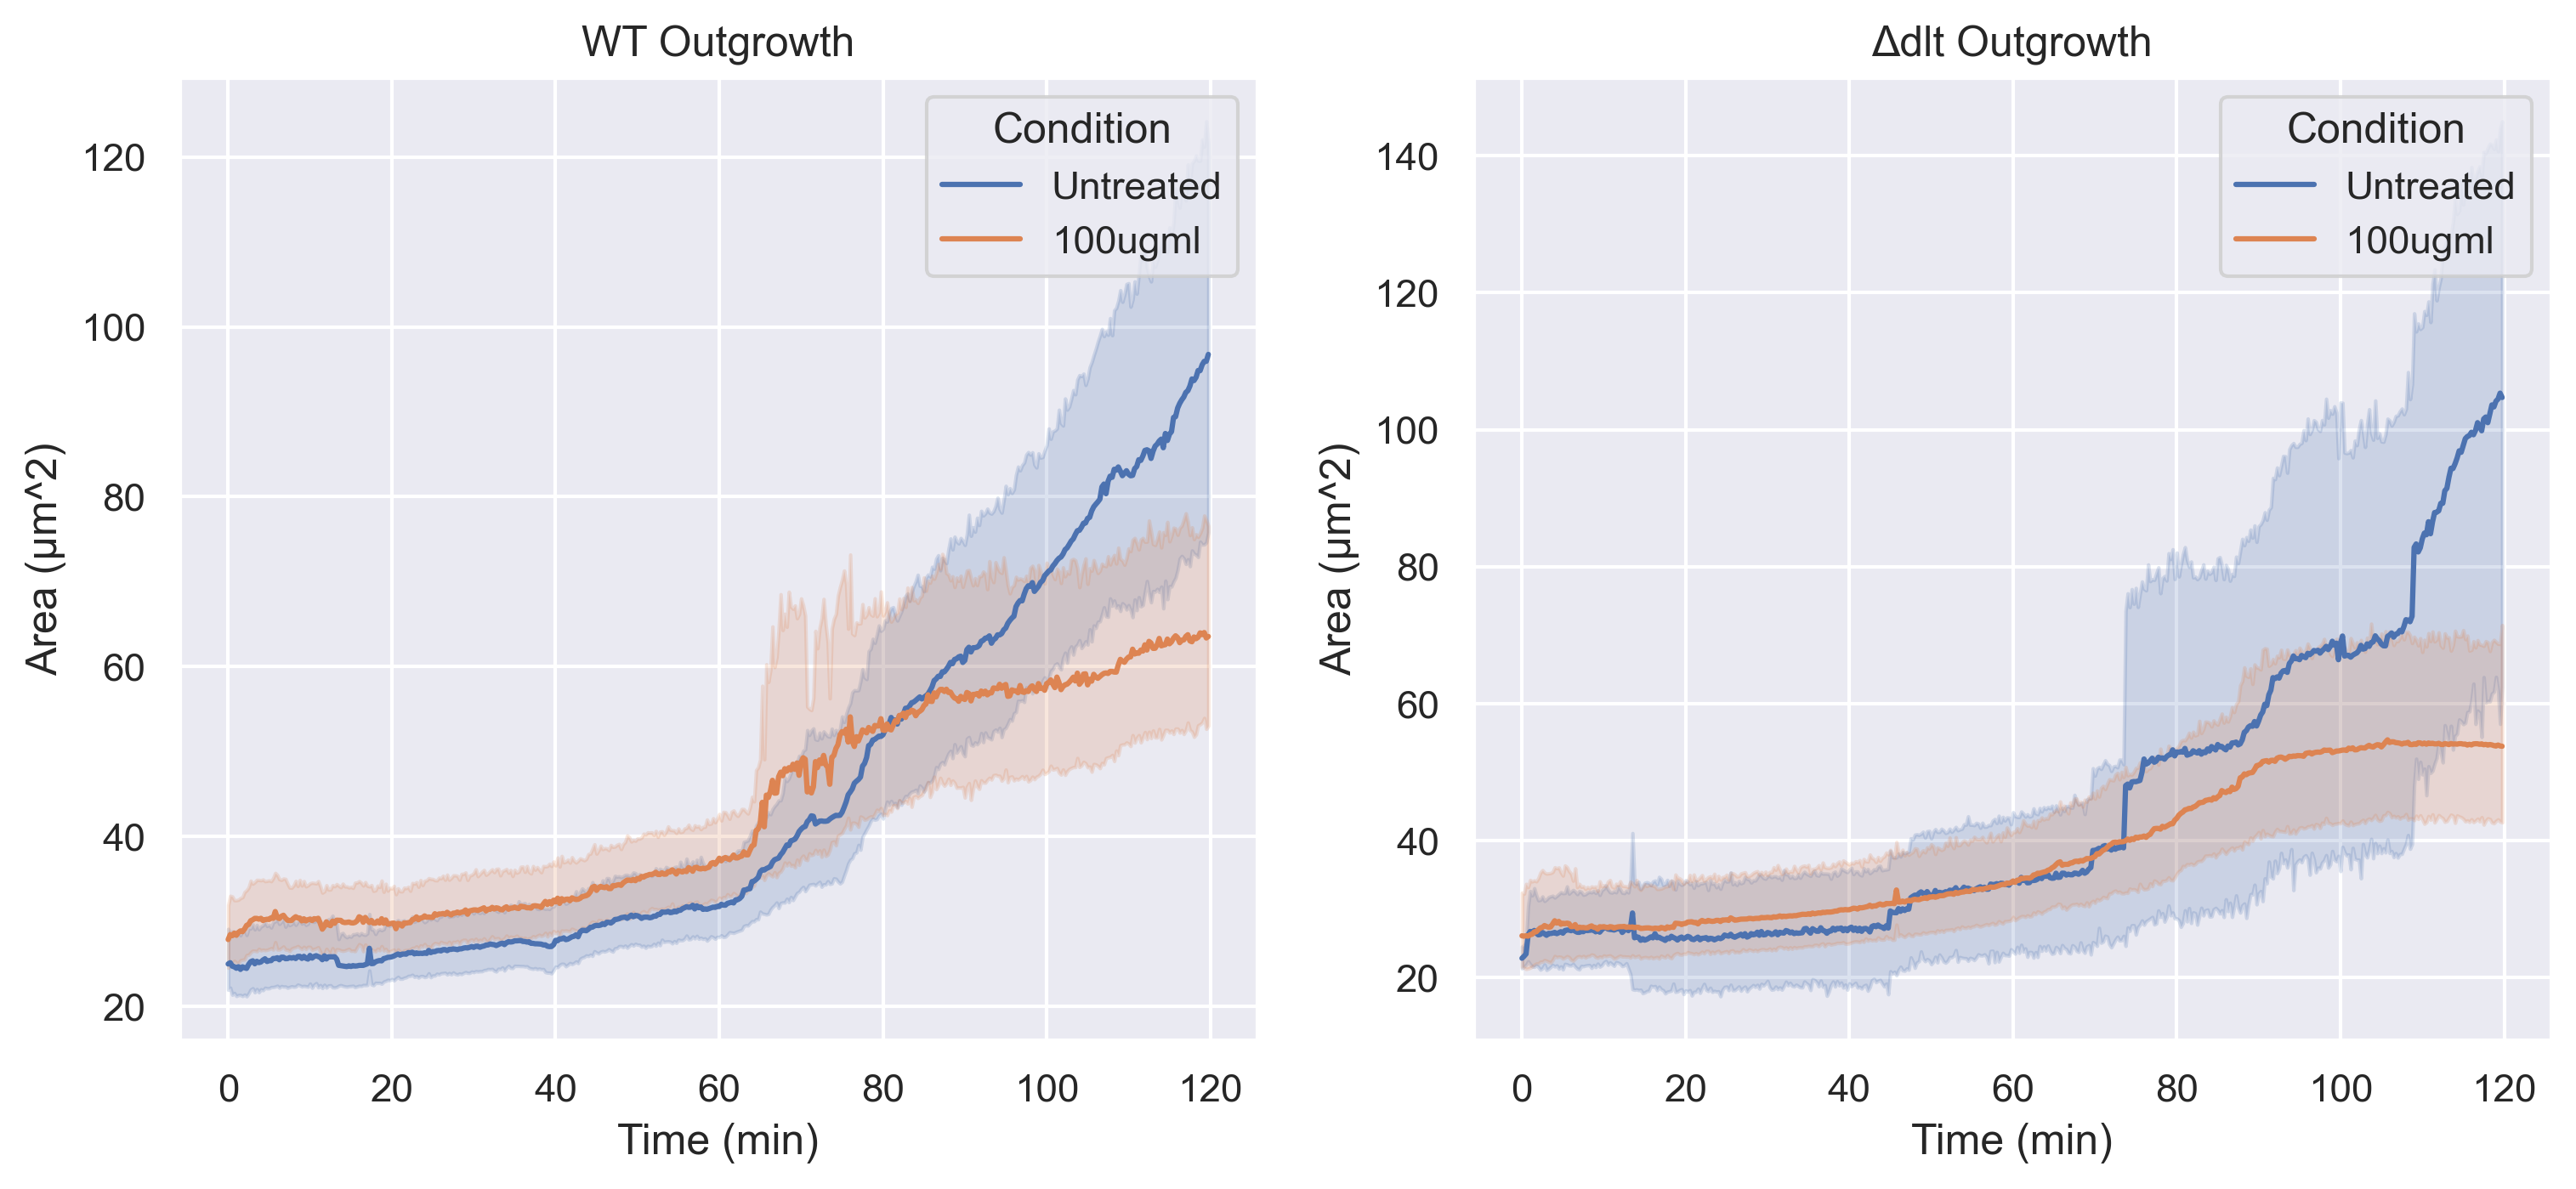

In [168]:
#plot outgrowth data 

outgrowth_raw['Time'] = (outgrowth_raw['Time'] * 15)/60
outgrowth_raw['area'] = (outgrowth_raw['area'] * 0.103)

#smoothing puts an nan for intensity in first row! Matlab function deals with this just fine...
#germ_clean['smooth_int'] = germ_clean['mean_intensity'].rolling(5).mean()

str1_out = outgrowth_raw[outgrowth_raw['Strain'] == '630']
str2_out = outgrowth_raw[outgrowth_raw['Strain'] == 'del_dlt']

#units allows you to plot multiple lines in the same hue. Just need to make sure that the estimator = none
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,5))
print(len(axes))
sns.lineplot(data = str1_out, x = 'Time', y = 'area', hue = 'Condition', ax = axes[0])#, units="Condition", estimator=None)
#sns.lineplot(data = germ_clean, x = 'Time', y = 'mean_intensity', hue = 'Condition', style ='Strain')
#ax2 = plt.twinx()
sns.lineplot(data = str2_out, x = 'Time', y = 'area', hue = 'Condition', ax = axes[1])

axes[0].set_title('WT Outgrowth')
axes[0].set(xlabel='Time (min)', ylabel='Area (μm^2)')
#axes[0].set_xlablel('Time (min)')
#axes[0].set_ylablel('Area (μm^2)')
axes[1].set_title('Δdlt Outgrowth')
axes[1].set(xlabel='Time (min)', ylabel='Area (μm^2)')
#axes[1].set_xlablel('Time (min)')
#axes[1].set_ylablel('Area (μm^2)')

6971


ValueError: Could not interpret value `derivative_savgol` for parameter `y`

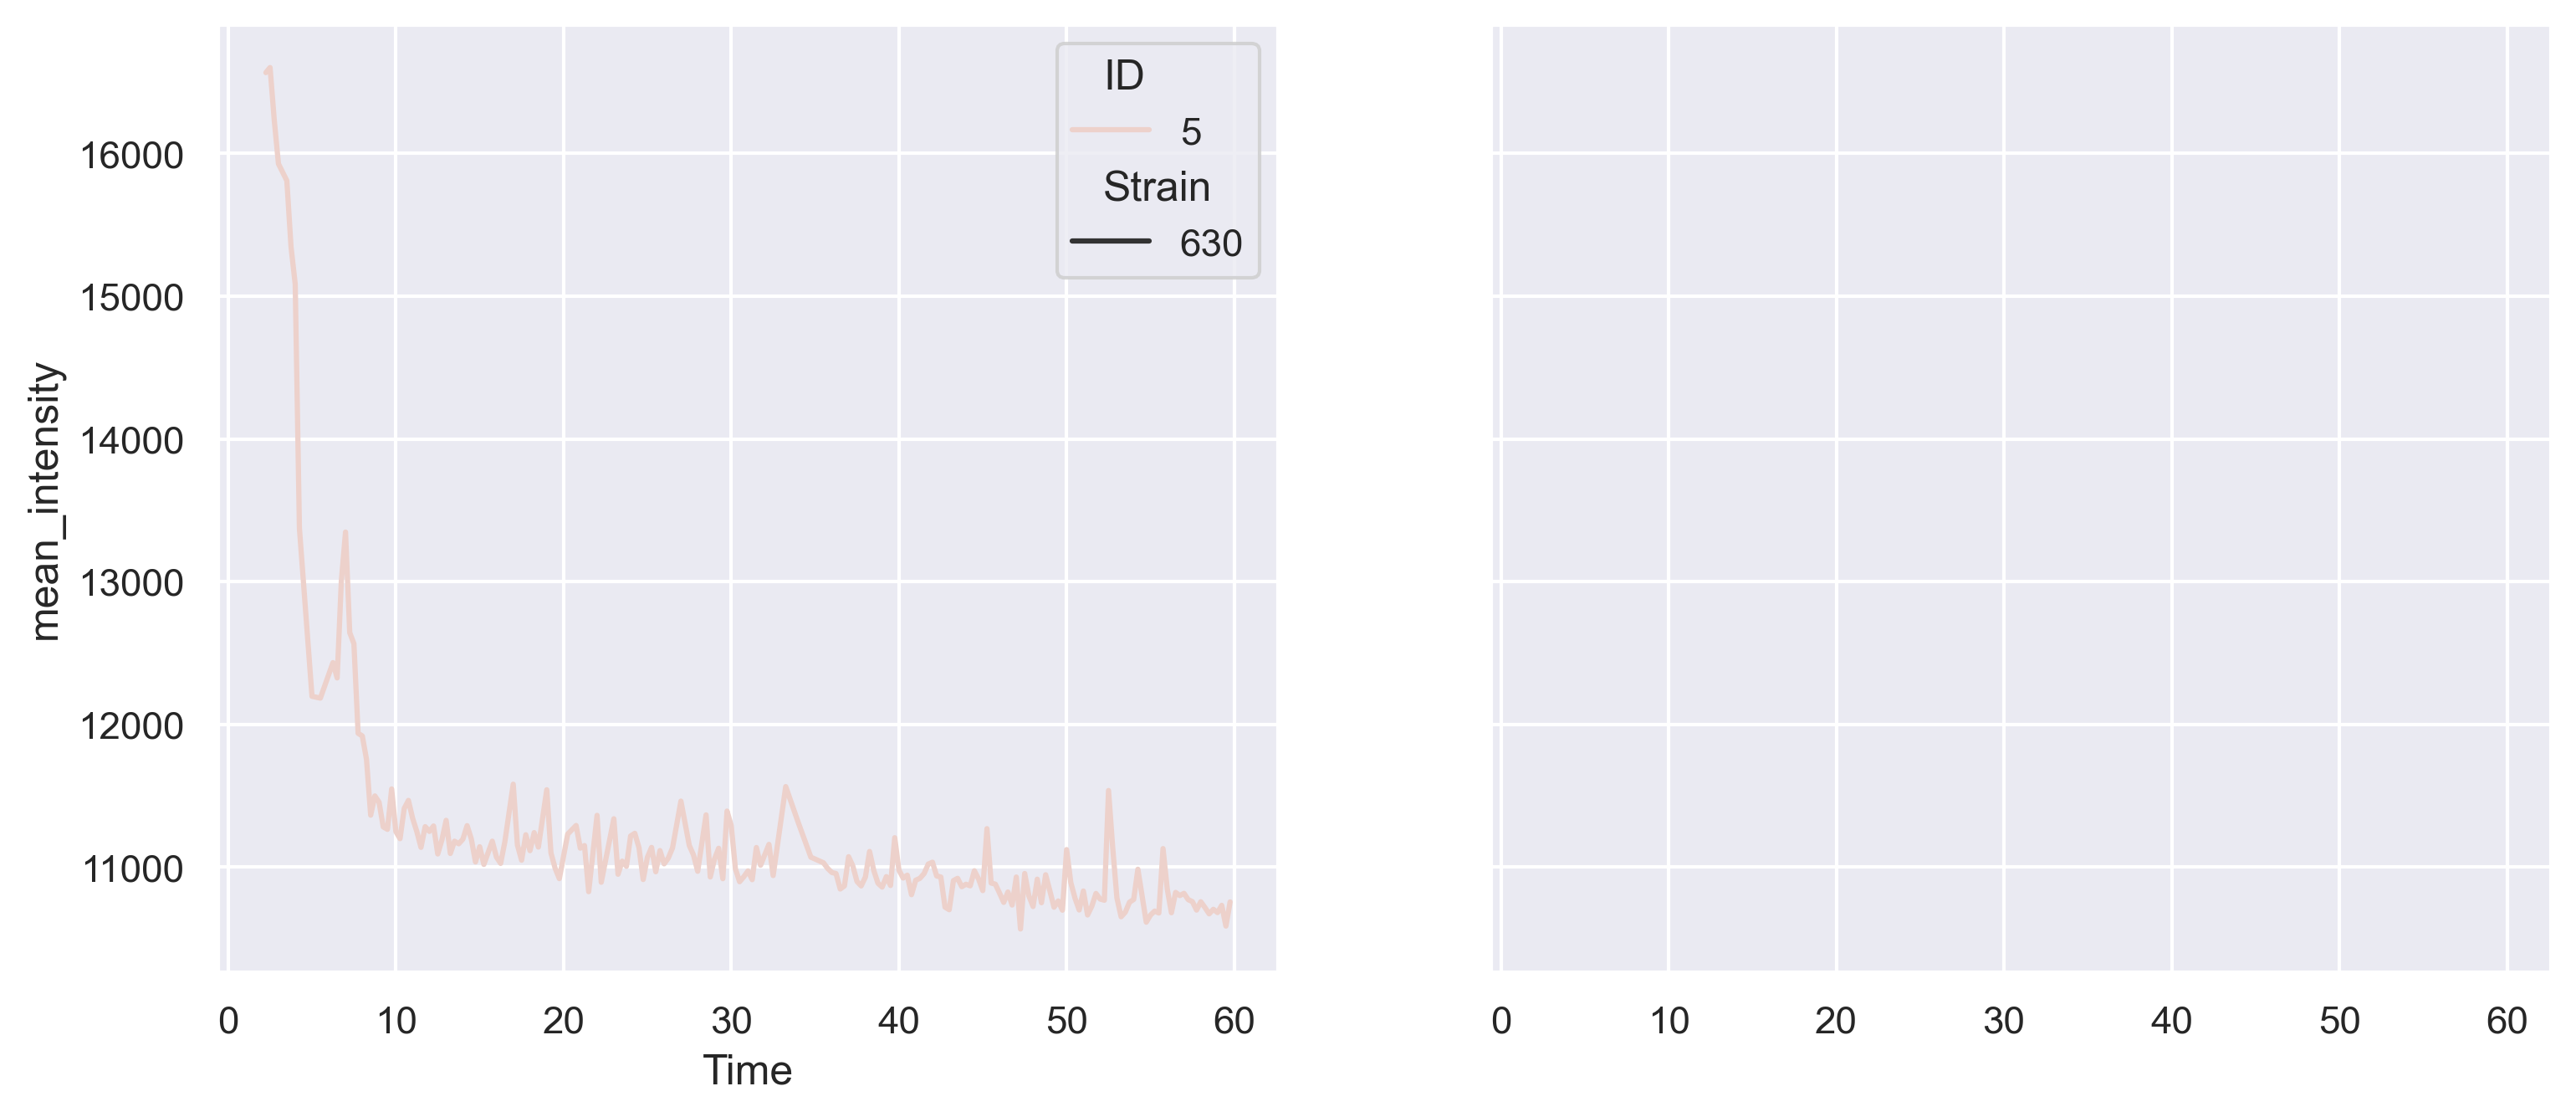

In [169]:
#Interpolate data and find derivatives
#pivot data to wide form for mean intesnity?

#Try Savitzky-Golay filter to smooth the data
import pyspore_utils as utils
from scipy.signal import savgol_filter
from scipy.ndimage.filters import uniform_filter1d

if 'savgol' in str1_germ.columns:
    str1_germ.pop('savgol')


dvis = utils.DataVis(str1_germ)
print(len(str1_germ.loc[:,['mean_intensity']]))

denoised = savgol_filter(str1_germ.loc[:,'mean_intensity'], window_length = 51, polyorder=2, mode = 'nearest')

str1_germ.insert(len(str1_germ.columns),column='savgol',value=denoised)
#str1_germ['smooth_int'] = uniform_filter1d(str1_germ.loc[:,['mean_intensity']], size = 5)

#str1_germ['smooth_int'] = str1_germ['mean_intensity'].rolling(6).mean()
#str1_germ['smooth_int'] = dvis.smooth_data(span = 5)

#Need to pass in conditions seperated with parentheses 
singlepos = str1_germ.loc[((str1_germ['Condition'] == 'Untreated') & (str1_germ['Position'] == 1))]
singlepos.head

# #fit pchip and get derivative
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,5))

sns.lineplot(data = singlepos.loc[singlepos['ID'] == 5], x = 'Time', y = 'mean_intensity', 
hue = 'ID', ax = axes[0], style='Strain')#, markers=True)
sns.lineplot(data = singlepos.loc[singlepos['ID'] == 5], x = 'Time', y = 'derivative_savgol', 
hue = 'ID', ax = axes[1], style='Strain')#, markers=True)
singlepos.head()

#fit pchip and get derivative

#sns.lineplot(data = pivoted, x ='Time', hue = 'Condition')

In [ ]:
#Try fitting pchip instead
from scipy.interpolate import PchipInterpolator 

if 'pchip' in str1_germ.columns:
    str1_germ.pop('pchip')


# dvis = utils.DataVis(str1_germ)

# #try subsetting each ID by strain, pos, and replicate.
# newdat = str1_germ.groupby())
# pchip_func = PchipInterpolator()

# start = 0
# stop = 60
# step = 0.25


# x_new = np.arange(start, stop, step)


# interpolated = pchip_func(x_new)

# str1_germ.insert(len(str1_germ.columns),column='pchip',value=interpolated)
# #str1_germ['smooth_int'] = uniform_filter1d(str1_germ.loc[:,['mean_intensity']], size = 5)

# #str1_germ['smooth_int'] = str1_germ['mean_intensity'].rolling(6).mean()
# #str1_germ['smooth_int'] = dvis.smooth_data(span = 5)

# #Need to pass in conditions seperated with parentheses 
# singlepos = str1_germ.loc[((str1_germ['Condition'] == 'Untreated') & (str1_germ['Position'] == 1))]
# singlepos.head

# # #fit pchip and get derivative
# fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,5))

# sns.lineplot(data = singlepos.loc[singlepos['ID'] == 5], x = 'Time', y = 'mean_intensity', 
# hue = 'ID', ax = axes[0], style='Strain')#, markers=True)
# sns.lineplot(data = singlepos.loc[singlepos['ID'] == 5], x = 'Time', y = 'pchip', 
# hue = 'ID', ax = axes[1], style='Strain')#, markers=True)
# singlepos.head()


<bound method NDFrame.head of       Condition Strain  Replicate  Position  Time  ID  bbox-0  bbox-1  bbox-2  \
335         NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
336         NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
337         NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
338         NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
339         NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
...         ...    ...        ...       ...   ...  ..     ...     ...     ...   
54150       NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
54152       NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
54178       NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
54190       NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN   
54198       NaN    NaN        NaN       NaN   NaN NaN     NaN     NaN     NaN  

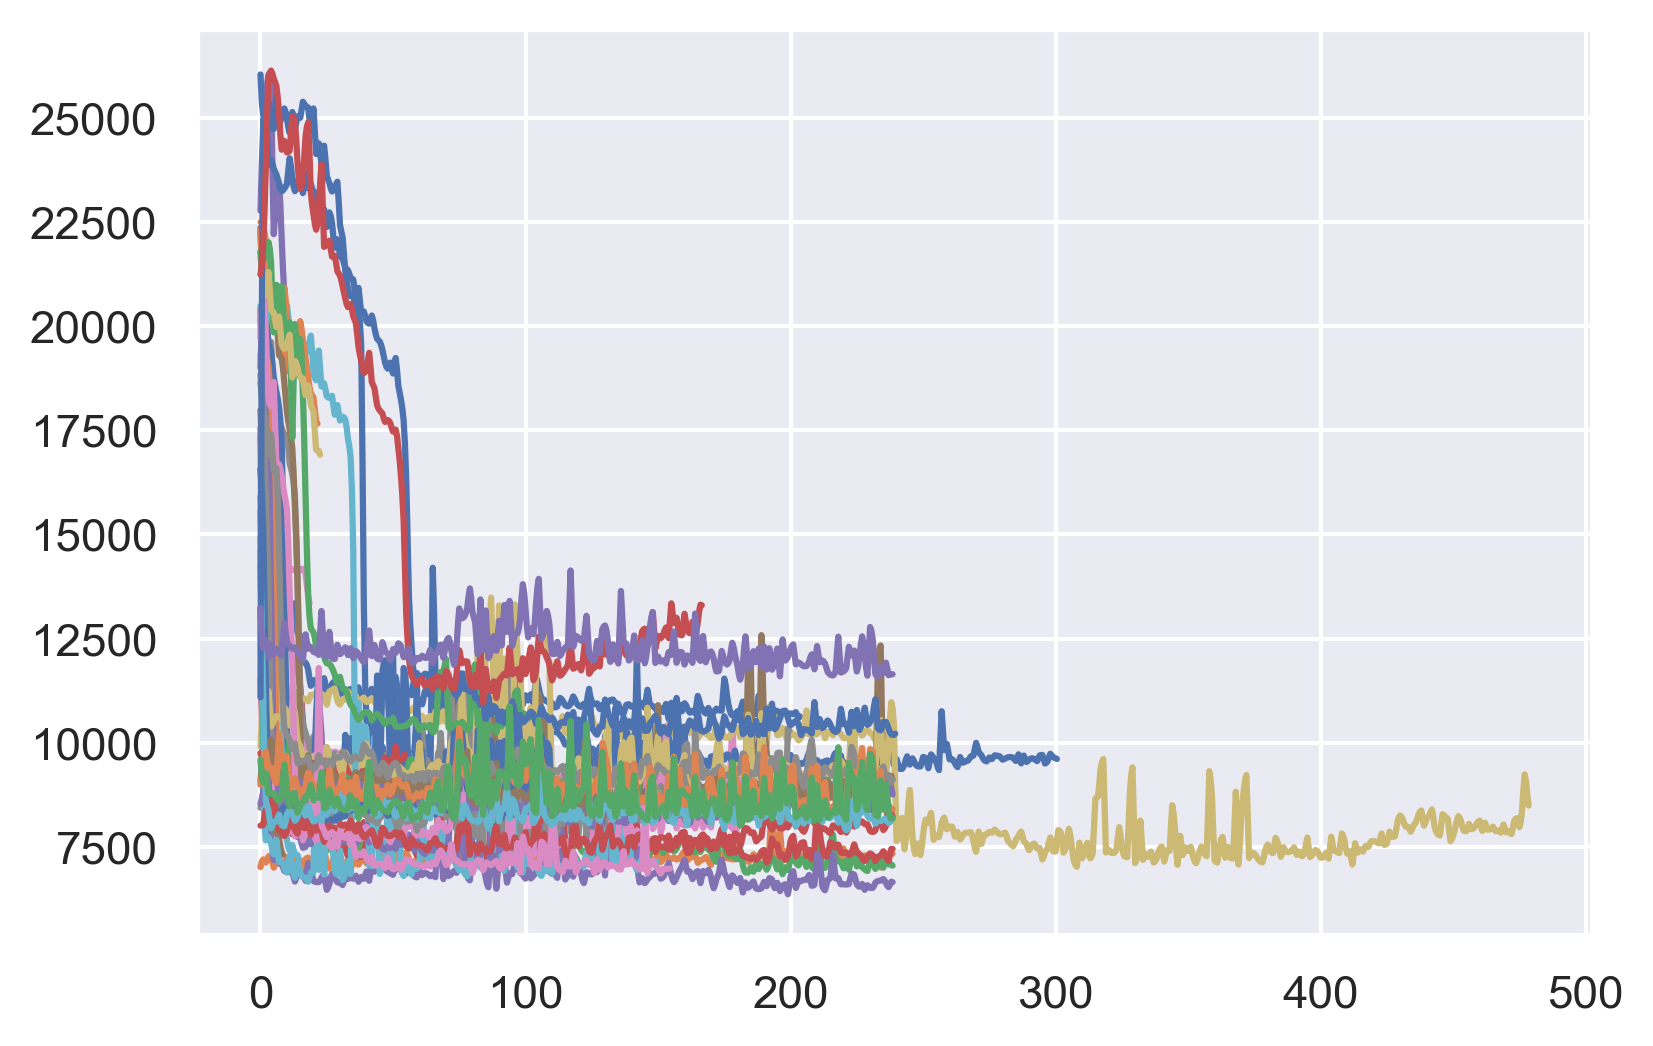

In [211]:
#remove spores that havent been tracked long enough



#group based on pos and ID to get pchip for mean intensity
def fit_pchip(df):
    #define vars
    x = range(len(df['Time']))
    
    y = df['mean_intensity']

    if len(x) < 10:
        return

    #print(y)
    pchip = PchipInterpolator(x,y, extrapolate=True)
    start = x[0]
    stop = x[-1]
    step = 0.5

    x_new = np.arange(start, stop, step)
   

    pchip = pchip(x_new)
    
    sns.lineplot(x = x_new, y = pchip)
    #Evaluate derivative of fx at each timepoint
   # df['derivatives'] = pchip.derivative(nu = 1)

    return df
#generate groupby object to iterate over each curve 
smoothed = str1_germ.groupby(['Strain','Replicate','Position', 'ID']).apply(fit_pchip)
smoothed.head

In [2]:
from joblib import cpu_count

print(cpu_count())

16
